In [1]:
# Import packages
import numpy as np
import cvxpy as cp
import mosek
import time
import math
from sklearn.model_selection import train_test_split

import phi_divergence as phi
import robust_sampling as rs
import dataio
import util

C:\Users\JSTARRE\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The problem we examine is as follows:

\begin{align}
\label{math_form:examples:pm2}
    \max_{\mathbf{x}}&~\theta \\
    \text{s.t.}&~\mathbf{r}^T \mathbf{x} \geq \theta \\
    &~\mathbf{e}^T \mathbf{x} = 1, \\
    &~\mathbf{x} \geq 0,
\end{align}

where $\mathbf{x}, \mathbf{r} \in \mathbb{R}^{k}$

In order to compare with Bertsimas, D., Gupta, V., & Kallus, N. (2018), we randomly generate $N$ synthetic returns for k assets, which is done as in Natarajan et al. (2008):

\begin{equation}
\tilde{r}_{i}=\left\{\begin{array}{ll}
\frac{\sqrt{\left(1-\gamma_{i}\right) \gamma_{i}}}{\gamma_{i}} & \text { with probability } \gamma_{i} \\[2mm]
-\frac{\sqrt{\left(1-\gamma_{i}\right) \gamma_{i}}}{1-\gamma_{i}} & \text { with probability } 1-\gamma_{i}
\end{array}, \quad \gamma_{i}=\frac{1}{2}\left(1+\frac{i}{k + 1}\right), \quad i=1, \ldots, k. \right.
\end{equation}

In [2]:
# Problem specific functions:
def generate_data(random_seed, k, N):
    np.random.seed(random_seed)
    gamma = np.fromiter((((1/2)*(1 + (i/(k+1)))) for i in range(1,k+1)), float)
    return_pos = np.fromiter(((math.sqrt((1-gamma[i])*gamma[i])/gamma[i]) for i in range(0,k)), float)
    return_neg = np.fromiter((-(math.sqrt((1-gamma[i])*gamma[i])/(1-gamma[i])) for i in range(0,k)), float)
    data = np.empty([N,k])
    for n in range(0, N):
        for i in range(0, k):
            prob = np.random.uniform()
            if prob <= gamma[i]:
                data[n, i] = return_pos[i]
            else:
                data[n, i] = return_neg[i]
    return data 

def solve_SCP(S, time_limit):
    k = S.shape[1]
    x = cp.Variable(k, nonneg = True)
    theta = cp.Variable(1)
    constraints = [theta - (S @ x) <= 0, cp.sum(x) == 1]
    obj = cp.Maximize(theta) # equivalent to min theta
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK, mosek_params = {mosek.dparam.optimizer_max_time: time_limit})
    x_value = np.concatenate((theta.value,x.value)) # Combine x and theta into 1 single solution vector
    return(x_value, prob.value)

def uncertain_constraint(S, x):
    return (x[0] - np.dot(S,x[1:])) # Assume that x[0] contains theta variable 

In [3]:
# Set parameter values (as in Bertsimas paper)
k = 10
alpha = 0.10
beta = 0.90
N_total = 500 
N_train = int(N_total / 2)
N_test = N_total - N_train

In [4]:
# Set other parameter values
par = 1
phi_div = phi.mod_chi2_cut
phi_dot = 2
numeric_precision = 1e-6 # To correct for floating-point math operations

In [46]:
# Get generated data
random_seed = 3
data = generate_data(random_seed, k, N_total)               
data_train, data_test = train_test_split(data, train_size=(N_train/N_total), random_state=random_seed)

In [6]:
# Run RS algorithms
time_limit_search = 0.1*60 # in seconds (time provided to search algorithm)
time_limit_solve = 5*60 # in seconds (for individuals solves of SCP)
max_nr_solutions = 10000 # for easy problems with long time limits, we may want extra restriction
add_remove_threshold = 0.00 # This determines when randomness is introduced in add/removal decision

add_strategy = 'random_vio'
remove_strategy = 'random_active'
clean_strategy = (15, 'all_inactive')

runtime_search, num_iter, solutions = rs.search_alg(data_train, N_test, beta, alpha, time_limit_search, time_limit_solve, 
                                                   max_nr_solutions, add_strategy, remove_strategy, clean_strategy, 
                                                   add_remove_threshold, 
                                                   par, phi_div, phi_dot, numeric_precision,
                                                   solve_SCP, uncertain_constraint, random_seed)

runtime_eval, best_sol, pareto_solutions = rs.evaluate_alg(solutions, data_test, beta, alpha, par, phi_div, phi_dot, 
                                                           uncertain_constraint, numeric_precision)

In [13]:
num_iter

{'add': 275, 'remove': 227, 'clean': 9}

In [14]:
runtime_eval

35.44584631919861

In [15]:
dataio.print_solution_info(best_sol)

obj: 0.21821789044215084
lb_train: 0.9409131300226462
lb_test: 0.9362753080468884
time_found: 11.959218263626099
scenario_set: [71, 207, 72, 119, 195, 149, 186]


In [9]:
VaR_bound = best_sol['sol'][0]
VaR_bound

-0.21821789044215084

In [10]:
best_sol['sol'][1:]

array([6.41462223e-10, 1.41928131e-10, 1.26633234e-09, 7.55859829e-10,
       2.01693965e-10, 1.00143405e-09, 1.02832164e-09, 2.47990442e-10,
       5.54571102e-10, 1.00000000e+00])

In [31]:
returns_test = np.dot(data_test, best_sol['sol'][1:])

In [29]:
# This should be the emperical VaR observed on test data 
np.percentile(a=returns_test, q=100*(1-beta), method='inverted_cdf')

0.21821788703483905

In [43]:
len(solutions)

1566

In [12]:
len(pareto_solutions)

10

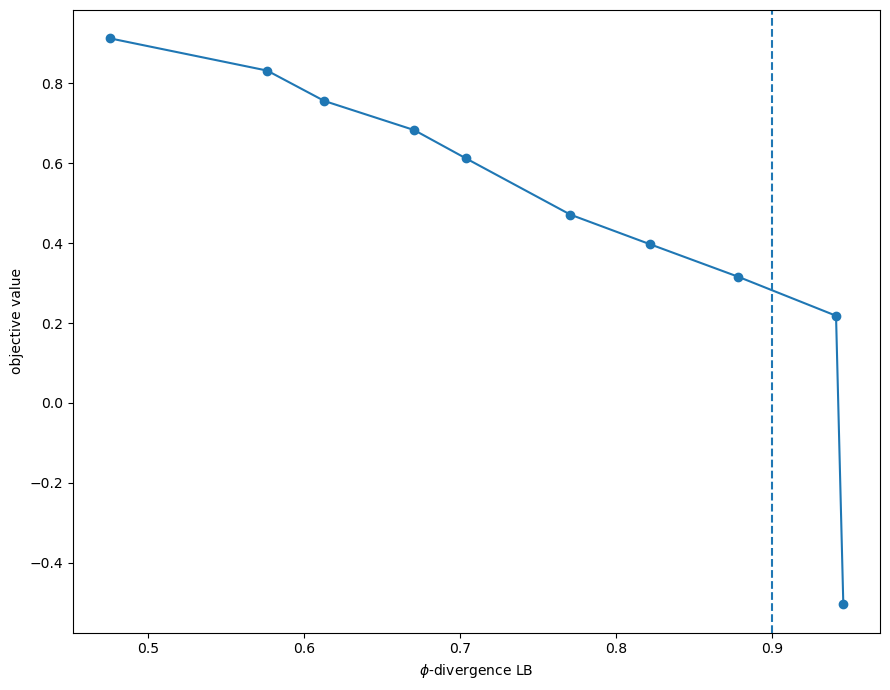

In [13]:
dataio.plot_pareto_curve(pareto_solutions, beta, None, None, None, None)

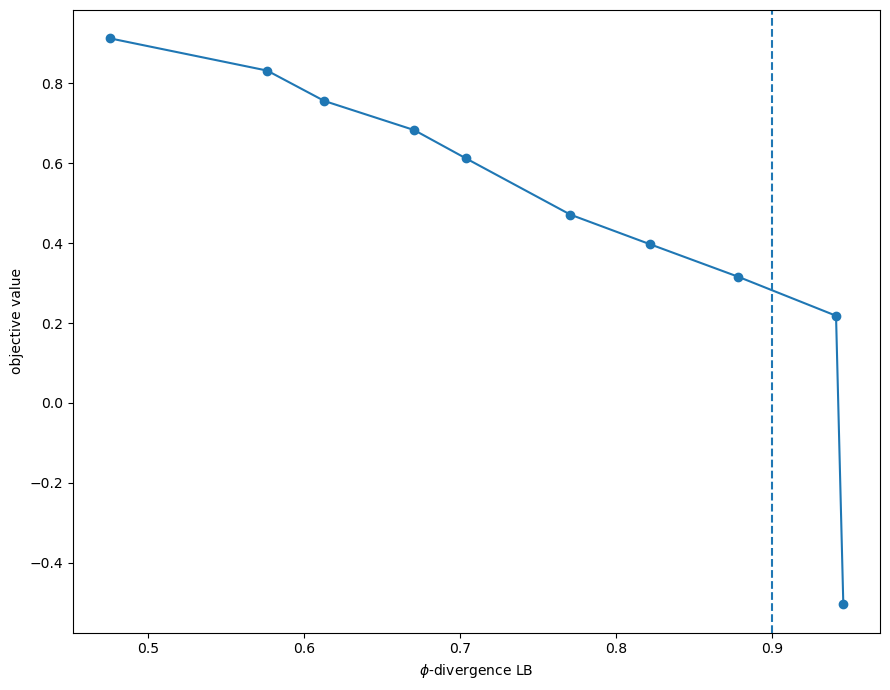

In [13]:
dataio.plot_pareto_curve(pareto_solutions, beta, None, None, None, None)

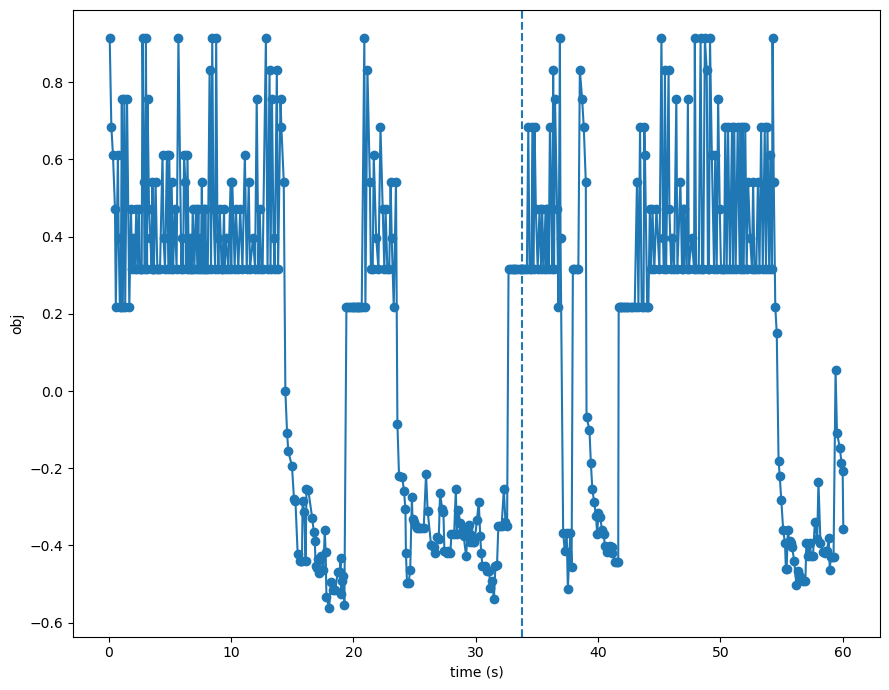

In [32]:
dataio.plot_obj_over_time(solutions, best_sol, None, None, None, None)

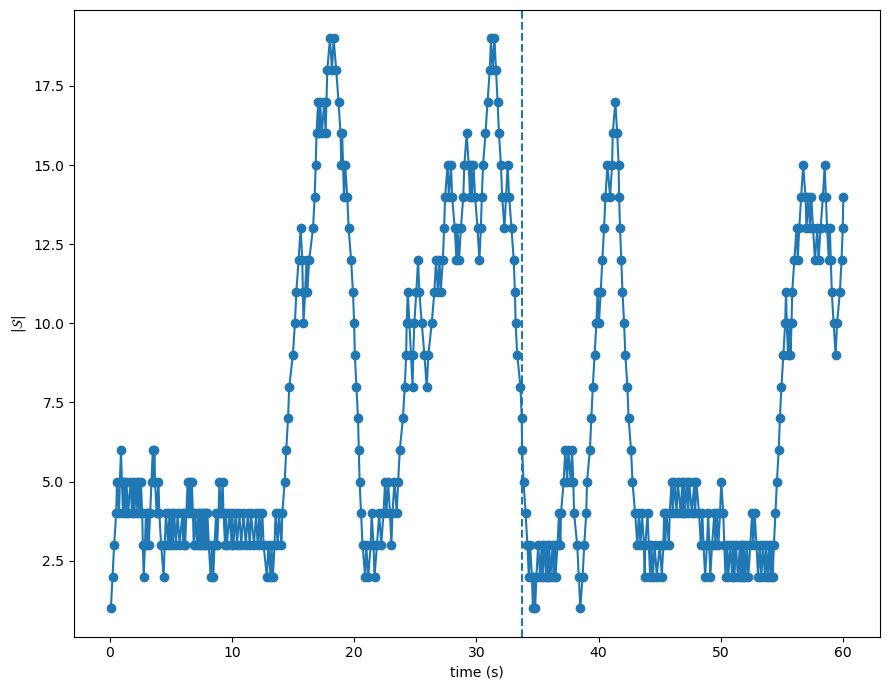

In [33]:
dataio.plot_size_set_over_time(solutions, best_sol, None, None, None, None)

# The following cells are used to obtain output and write to latex tables

In [7]:
headers = ['seed', 
           'sol', 'obj', 'lb_{train}', 'lb_{test}', 'True Prob.', 'True VaR', 'True CVaR',
           '\#Iter.~(add)', '\#Iter.~(remove)', '\#Iter.~(clean)', '$|\mathcal{X}|$',
           '$|\mathcal{S}_{max}|$', 'Time Found',
          'N_{Campi}', 'obj_{Campi}', 'solvetime_{Campi}']

output_data = {}

# Set parameter values (as in Bertsimas paper)
k = 10
alpha = 0.10
#alpha = 0.000001
beta = 0.90
N_total = 500 
N_train = int(N_total / 2)
N_test = N_total - N_train
N_campi = util.determine_campi_N_min(k, beta, alpha)

N_eval = 1000000
seed_eval = 987
data_eval = generate_data(seed_eval, k, N_eval)

# Other parameter values
par = 1
phi_div = phi.mod_chi2_cut
phi_dot = 2
numeric_precision = 1e-6 # To correct for floating-point math operations

# Alg parameters
time_limit_search = 1*60 # in seconds (time provided to search algorithm)
time_limit_solve = 5*60 # in seconds (for individuals solves of SCP)
max_nr_solutions = 10000 # for easy problems with long time limits, we may want extra restriction
add_remove_threshold = 0.00 # This determines when randomness is introduced in add/removal decision
add_strategy = 'random_vio'
remove_strategy = 'random_active'
clean_strategy = (10, 'all_inactive')

random_seed_settings = [i for i in range(1, 11)]

run_count = 0
for random_seed in random_seed_settings:
    
    data = generate_data(random_seed, k, N_total)               
    data_train, data_test = train_test_split(data, train_size=(N_train/N_total), random_state=random_seed)
    data_campi = generate_data(random_seed, k, N_campi)
    campi_runtime, campi_x, campi_obj = util.solve_with_campi_N(solve_SCP, data_campi, time_limit_solve)
    

    runtime_search, num_iter, solutions = rs.search_alg(data_train, N_test, beta, alpha, time_limit_search, time_limit_solve, 
                                                       max_nr_solutions, add_strategy, remove_strategy, clean_strategy, 
                                                       add_remove_threshold,  
                                                       par, phi_div, phi_dot, numeric_precision,
                                                       solve_SCP, uncertain_constraint, random_seed)

    runtime_eval, best_sol, pareto_solutions = rs.evaluate_alg(solutions, data_test, beta, alpha, par, phi_div, phi_dot, 
                                                               uncertain_constraint, numeric_precision)
    
    # Get "true" performance using eval_data
    constr = uncertain_constraint(data_eval, best_sol['sol'])
    num_violations = np.count_nonzero(constr > (0+numeric_precision))
    p_eval = 1 - (num_violations/N_eval)
    
    # We are also interested in the "true" VaR and CVaR under data_eval
    returns_eval = np.dot(data_eval, best_sol['sol'][1:])
    VaR_eval = np.percentile(returns_eval, 100*(1-beta), method='inverted_cdf')
    CVaR_eval = np.mean(returns_eval[(returns_eval <= VaR_eval)])
    
    # Get max scenario_set size
    max_S = 0
    for sol in solutions:
        S = len(sol['scenario_set'])
        if S > max_S:
            max_S = S
        
    output_data[random_seed] = [best_sol['sol'], best_sol['obj'], best_sol['lb_train'], best_sol['lb_test'],
                                     p_eval, VaR_eval, CVaR_eval, num_iter['add'], num_iter['remove'], num_iter['clean'],
                                     len(solutions), max_S, best_sol['time'],
                               N_campi, campi_obj, campi_runtime]
        
    run_count += 1
    print("Completed run: " + str(run_count))
    
output_file_name = 'new_output_data'
with open(r'output/'+output_file_name+'.txt','w+') as f:
    f.write(str(output_data))

Completed run: 1
Completed run: 2
Completed run: 3
Completed run: 4
Completed run: 5
Completed run: 6
Completed run: 7
Completed run: 8
Completed run: 9
Completed run: 10
Completed run: 11
Completed run: 12
Completed run: 13
Completed run: 14
Completed run: 15
Completed run: 16
Completed run: 17
Completed run: 18
Completed run: 19
Completed run: 20
Completed run: 21
Completed run: 22
Completed run: 23
Completed run: 24
Completed run: 25
Completed run: 26
Completed run: 27
Completed run: 28
Completed run: 29
Completed run: 30
Completed run: 31
Completed run: 32
Completed run: 33
Completed run: 34
Completed run: 35
Completed run: 36
Completed run: 37
Completed run: 38
Completed run: 39
Completed run: 40
Completed run: 41
Completed run: 42
Completed run: 43
Completed run: 44
Completed run: 45
Completed run: 46
Completed run: 47
Completed run: 48
Completed run: 49
Completed run: 50
Completed run: 51
Completed run: 52
Completed run: 53
Completed run: 54
Completed run: 55
Completed run: 56
C

In [26]:
# Aggregate data to get avg and stddev across random seed runs
import pandas as pd

output_data_agg = {}
df_VaR = pd.DataFrame({key: pd.Series(val[5]) for key, val in output_data.items()})
df_Sol = pd.DataFrame({key: pd.Series(val[0]) for key, val in output_data.items()})
df_Sol = df_Sol.T

In [14]:
df_VaR.mean(axis=1)

0    0.265263
dtype: float64

In [17]:
df_VaR.std(axis=1)

0    0.049212
dtype: float64

In [29]:
df_Sol.drop(0, axis=1, inplace=True)
df_Sol

,1,2,3,4,5,6,7,8,9,10
1,0.000000e+00,0.000000e+00,1.305565e-11,0.000000e+00,1.724659e-11,1.485790e-11,1.896377e-11,2.426948e-11,1.000000e+00,2.087777e-11
2,0.000000e+00,4.961967e-10,1.055635e-08,0.000000e+00,9.013691e-09,1.767046e-09,1.987414e-09,1.935390e-10,4.638350e-09,1.000000e+00
3,0.000000e+00,1.139630e-09,0.000000e+00,1.305234e-09,7.962448e-10,5.889729e-10,1.798656e-09,5.191697e-13,9.882403e-10,1.000000e+00
4,1.398549e-11,1.085142e-12,5.288126e-10,6.025692e-12,3.524877e-11,5.474003e-11,4.201026e-12,5.855323e-11,1.000000e+00,1.794734e-10
5,0.000000e+00,9.798421e-10,6.968092e-10,1.436085e-09,1.397422e-09,7.340758e-10,6.298802e-10,1.036522e-09,6.794706e-10,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...
96,0.000000e+00,1.060215e-10,3.051113e-11,2.060116e-10,1.975816e-10,7.657537e-11,2.501404e-10,1.433076e-10,1.000000e+00,2.875931e-09
97,0.000000e+00,5.966655e-11,2.946988e-11,2.799481e-12,1.753227e-11,1.930520e-11,2.704418e-11,1.348664e-11,2.196400e-11,1.000000e+00
98,0.000000e+00,0.000000e+00,3.629961e-09,6.524717e-10,3.784156e-09,3.349475e-09,2.148761e-09,1.925884e-09,2.727652e-09,1.000000e+00
99,2.101877e-09,4.243884e-11,4.346025e-11,4.001098e-11,1.804173e-10,9.909110e-10,3.468654e-10,5.649444e-11,8.788753e-15,1.000000e+00


In [31]:
solutions = df_Sol
k = len(solutions.columns)


10

In [36]:
# get quantiles and mean for each asset seperately
q_10 = []
means = []
q_90 = []
for i in solutions.columns:
    means.append(np.mean(solutions.loc[:,i]))
    q_10.append(np.percentile(solutions.loc[:,i], 10))
    q_90.append(np.percentile(solutions.loc[:,i], 90))

In [35]:
means

[1.7781961126568656e-10,
 8.734845931333032e-10,
 8.003267102780111e-10,
 5.578174421475231e-10,
 9.138840914338881e-10,
 5.894299715171184e-10,
 6.271535595041751e-10,
 4.918156888834423e-10,
 0.4800000001807554,
 0.5199999989484745]

In [37]:
q_10

[0.0,
 0.0,
 0.0,
 1.2706460824793303e-14,
 1.4210320092448384e-13,
 2.672001346916665e-13,
 8.815926709544783e-13,
 6.132527749460389e-13,
 3.357451820342648e-11,
 2.0441868472190193e-11]

In [38]:
q_90

[3.775791570648164e-12,
 2.1122613135667918e-09,
 2.112227578845307e-09,
 1.5954515935242178e-09,
 2.7276793553741896e-09,
 1.7981231957906623e-09,
 2.1495542047996075e-09,
 1.9162494140728847e-09,
 1.0000000000880578,
 1.0000000001790046]

In [39]:
import matplotlib.pyplot as plt

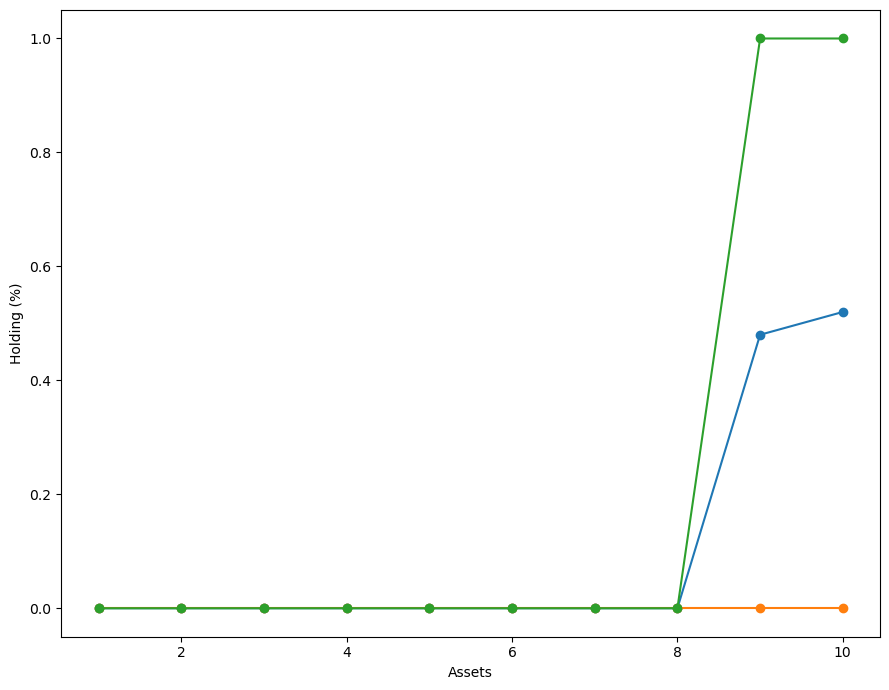

In [42]:
x = solutions.columns
plt.plot(x, means, '-o')
plt.plot(x, q_10, '-o')
plt.plot(x, q_90, '-o')
plt.xlabel("Assets")
plt.ylabel("Holding (%)")
plt.tight_layout()
plt.show()

In [ ]:
headers_agg = ['sol', 'obj', 'lb_{train}', 'lb_{test}', 'True Prob.', 'True VaR', 'True CVaR',
           '\#Iter.~(add)', '\#Iter.~(remove)', '\#Iter.~(clean)', '$|\mathcal{X}|$',
           '$|\mathcal{S}_{max}|$', 'Time Found',
          'N_{Campi}', 'obj_{Campi}', 'solvetime_{Campi}']


dataio.write_output_to_latex(3, headers_agg, output_data_agg)
